# Filter

basially a dup of flare filtering

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


## Download

In [2]:
download_chandra_obsid 1843 evt2
mv 1843/primary/acisf01843N004_evt2.fits.gz .
gunzip -f acisf01843N004_evt2.fits.gz
rmdir -p 1843/primary


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt2     fits       17 Mb    already downloaded



## Restrict Energy Rnage

In [3]:
dmcopy "acisf01843N004_evt2.fits[energy=300:10000]" acis_1843_evt2_0.3-10.fits  clob+

## Using exclude filter

In [4]:
dmcopy "acisf01843N004_evt2.fits[exclude ccd_id=0:4,6,8:9]" acis_1843_evt2_bi.fits clob+

In [5]:
dmcopy "acisf01843N004_evt2.fits[exclude ccd_id=0:4,6,8:9]" acis_1843_evt2_bi.fits  clob+

## Apply Time Filters


In [6]:
dmcopy "acisf01843N004_evt2.fits[time=60413209:60414209]" acis_1843_evt2_1000s.fits clob+

## High Background Times

In [7]:
cat << EOM > obj.reg 
# Region file format: CIAO version 1.0
ellipse(1628,4116,100,140,0)
EOM


In [8]:
ds9 acis_1843_evt2_0.3-10.fits -region obj.reg -bin factor 8 -scale log  \
  -saveimage png ds9_01.png &
sleep 10
xpaset -p ds9 quit


display < ds9_01.png

[1] 34029
[1]+  Done                    ds9 acis_1843_evt2_0.3-10.fits -region obj.reg -bin factor 8 -scale log -saveimage png ds9_01.png


### 3. Extract background light curve

In [9]:
pset dmextract \
    infile="acis_1843_evt2_0.3-10.fits[sky=field()-ellipse(1628,4116,100,140,0)][bin time=::3.24104]"
pset dmextract outfile=background_lc.fits
pset dmextract opt=ltc1
dmextract mode=h clob+

## 4. Examine lc

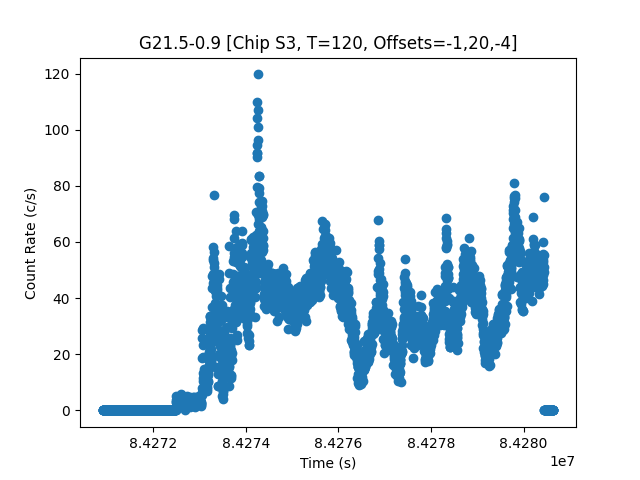

In [10]:
cat << EOM > c1.py
from pycrates import read_file
import matplotlib.pylab as plt

tab = read_file("background_lc.fits")
xx = tab.get_column("time").values
yy = tab.get_column("count_rate").values

plt.plot(xx,yy,marker="o",linestyle="")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (c/s)")
plt.title("G21.5-0.9 [Chip S3, T=120, Offsets=-1,20,-4]")
plt.savefig("plot_01.png")
EOM

python c1.py
display < plot_01.png

In [11]:
dmstat "background_lc.fits[cols count_rate]" 

COUNT_RATE[count/s]
    min:	0 	      @:	1 
    max:	119.68749977 	      @:	1037 
   mean:	28.817847829 
  sigma:	19.887784535 
    sum:	86655.268422 
   good:	3007 
   null:	0 



In [12]:
dmlist "background_lc.fits[cols time,count_rate][#row=1030:1045]" data

 
--------------------------------------------------------------------------------
Data for Table Block LIGHTCURVE
--------------------------------------------------------------------------------
 
ROW    TIME                 COUNT_RATE
 
     1  84274238.8191800117        90.3124998250
     2  84274242.0602200031        91.5624998226
     3  84274245.3012599945       109.6874997875
     4  84274248.5423000157       104.0624997984
     5  84274251.7833400071        91.5624998226
     6  84274255.0243799984        96.2499998135
     7  84274258.2654200196       100.9374998044
     8  84274261.5064600110       119.6874997681
     9  84274264.7475000024       106.8749997929
    10  84274267.9885400236        66.5624998710
    11  84274271.2295800149        69.6874998650
    12  84274274.4706200063        68.1249998680
    13  84274277.7116599977        77.4999998498
    14  84274280.9527000189        74.0624998565
    15  84274284.1937400103        83.4374998383
    16  84274287.434780001

In [13]:
dmlist "background_lc.fits[cols time,count_rate][count_rate>65]" data | head -20

 
--------------------------------------------------------------------------------
Data for Table Block LIGHTCURVE
--------------------------------------------------------------------------------
 
ROW    TIME                 COUNT_RATE
 
     1  84273308.6407000124        76.5624998516
     2  84273742.9400600195        69.6874998650
     3  84273746.1811000109        68.1249998680
     4  84274229.0960600078        70.6249998632
     5  84274232.3370999992        79.6874998456
     6  84274235.5781400204        94.3749998171
     7  84274238.8191800117        90.3124998250
     8  84274242.0602200031        91.5624998226
     9  84274245.3012599945       109.6874997875
    10  84274248.5423000157       104.0624997984
    11  84274251.7833400071        91.5624998226
    12  84274255.0243799984        96.2499998135
    13  84274258.2654200196       100.9374998044


### Create GTI

In [14]:
pset dmgti infile=background_lc.fits
pset dmgti outfile=bkg_gti.fits
pset dmgti userlimit="count_rate<=80.0"
dmgti clobber=yes mode=h

In [15]:
dmlist bkg_gti.fits blocks,subspace

 
--------------------------------------------------------------------------------
Dataset: bkg_gti.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: PRIMARY                        Null        
Block    2: FILTER                         Table         1 cols x 0        rows
Block    3: GTI                            Table         2 cols x 5        rows
 
--------------------------------------------------------------------------------
Data subspace for block FILTER: Components: 1 Descriptors: 1 
--------------------------------------------------------------------------------
 
 --- Component 1 --- 
   1 TIME                 Real8               TABLE GTI
                                              
                                               84270902.1685000062: 84274233.9576200247
         

### 6. Apply


In [16]:
dmcopy "acis_1843_evt2_0.3-10.fits[@bkg_gti.fits]" acis_1843_evt2_0.3-10_bkgflt.fits  clob+



### 7. Check

In [17]:
dmlist acis_1843_evt2_0.3-10.fits header | grep EXPO

0117 EXPOSURE                  7854.4664748540 [s]       Real8        Exposure time
0118 EXPOSUR7                  7854.4664748540 [s]       Real8        Exposure time
0119 EXPOSUR6                  7854.4664748540 [s]       Real8        Exposure time
0120 EXPOSUR3                  7851.2665536036 [s]       Real8        Exposure time
0121 EXPOSUR2                  7854.4664748540 [s]       Real8        Exposure time
0122 EXPOSUR1                  7854.4664748540 [s]       Real8        Exposure time
0123 EXPOSUR0                  7854.4664748540 [s]       Real8        Exposure time


In [18]:
dmlist acis_1843_evt2_0.3-10_bkgflt.fits header | grep EXPO

0117 EXPOSURE                  7812.8664748764 [s]       Real8        Exposure time
0118 EXPOSUR7                  7812.8664748764 [s]       Real8        Exposure time
0119 EXPOSUR6                  7812.8664748764 [s]       Real8        Exposure time
0120 EXPOSUR3                  7809.6665536260 [s]       Real8        Exposure time
0121 EXPOSUR2                  7812.8664748764 [s]       Real8        Exposure time
0122 EXPOSUR1                  7812.8664748764 [s]       Real8        Exposure time
0123 EXPOSUR0                  7812.8664748764 [s]       Real8        Exposure time


# Cleanup


In [19]:
/bin/rm acisf01843N004_evt2.fits